In [3]:
from torchvision import transforms, utils
import scipy.io as sc
import torch
import numpy as np
import torch.nn as nn
from time import process_time
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import ticker
from PIL import Image
import tensorly as tl
from tensorly.decomposition import parafac
from torch.utils.data import Dataset, DataLoader
import random as rd
import torch.optim as optim
import torch

# Defining ICDAR unpacker

In [4]:
class ICDAR_Dataset(Dataset):

    def __init__(self, file, lim=-1, shuffle=True, transform=None):
        self.transform = transform
        frame = sc.loadmat(file)
        alpha = alphabet()
        s, t = [], []

        if lim != -1:
            n_samples, res = lim // 36, lim % 36
        else:
            n_samples, res = 100000, 0

        for i in range(len(frame["images"][0])):  # All the categories
            char_list = frame["images"][0][i][0]
            for j in range(min(n_samples, len(char_list))):
                s.append(char_list[j])
                t.append(alpha[frame["labels"][0][i][0]])

        self.samples = torch.tensor(s).float()
        self.targets = torch.tensor(t)

        # uniqueValues, occurCount = np.unique(self.targets, return_counts=True)
        # print(uniqueValues, occurCount)

        self.len = len(self.samples)
        self.indexes = [i for i in range(len(self.samples))]

        if shuffle:
            rd.shuffle(self.indexes)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        

        img = self.samples[self.indexes[idx]]
        label = self.targets[self.indexes[idx]]+1

        img.type(torch.uint8)
        target = int(label)

        if self.transform is not None:
            img = Image.fromarray(img.numpy())
            img = self.transform(img)

        return img, target

    def shuffle(self):
        return rd.shuffle(self.indexes)


def alphabet():
    alpha = {}
    for i in range(10):
        alpha[str(i)] = i

    for i in range(26):
        alpha[chr(65 + i)] = i + 10

    return alpha 

class normalize(object):
    """Normalizes tensor image"""

    def __call__(self, sample):
        # input and output are both torch image: C X H X W 
        c,h,w = sample.size() #get the size of the image
        image = torch.reshape(sample,(-1,1))
        image = (image-torch.mean(image))/(torch.std(image))
        image = torch.reshape(image,(c,h,w))

        return image
    
class testnormalize(object):
    
    def __call__(self, sample):
        image = (sample-torch.mean(sample))/(torch.std(sample))
        return image

# Defining CharNet Classes

## CharNet

In [5]:
log_interval = 50


class CharNet(nn.Module):
    def __init__(self):
        super(CharNet, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss() # Original Loss function
        #self.loss_fn = nn.NLLLoss()  #Changed Loss Function

    def exec(self, x_train, x_test, optimizer, n_epochs, device = "cpu"):
        start_time = process_time()
        train_losses = []
        train_counter = []
        test_losses = []
        accuracy_score = []
        test_counter = [i * len(x_train.dataset) for i in range(n_epochs + 1)]
        self._test(x_test, test_losses, accuracy_score, device)  # To check the random choice option
        for epoch in range(1, n_epochs + 1):
            self._train(epoch, x_train, optimizer, train_losses, train_counter, device)

            self._test(x_test, test_losses, accuracy_score, device)

        print("\n Total Time Elapsed ({} epochs) : {:.3f}".format(n_epochs, process_time() - start_time))
        return None

    def plot_res(self, train_losses, train_counter, test_losses, test_counter, accuracy_score):

        # Likelihood loss (part III)
        plt.plot(train_counter, train_losses, color='blue')
        plt.scatter(test_counter, test_losses, color='red')
        plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('number of training examples seen')
        plt.ylabel('negative log likelihood loss')

        # Accuracy (part III)
        plt.figure()
        plt.plot(accuracy_score)
        plt.xlabel('Number of epochs')
        plt.ylabel('Accuracy')

        return plt.show()

    def _train(self, epoch, x_train, optimizer, train_losses, train_counter, device="cpu"):
        self.train()
        for batch_idx, (data, target) in enumerate(x_train):
            data = data.to(device)
            target = target.to(device)
            #optimizer.zero_grad()# relocated this command
            output = self.forward(data)
            loss = self.loss_fn( output,  target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(x_train.dataset),
                           100. * batch_idx / len(x_train), loss.item()))
                train_losses.append(loss.item())#self._test(x_train, [], [])
                train_counter.append(
                    (batch_idx * 64) + ((epoch - 1) * len(x_train.dataset)))

    def _test(self, x_test, test_losses, accuracy_score, device="cpu"):
        start = process_time()
        self.eval()  # network in evaluation mode (for batchnorm and dropout layers)
        test_loss = 0
        correct = 0
        with torch.no_grad():  # deactivate the autograd engine to reduce memory usage and speed up
            for (data, target) in x_test:
                data = data.to(device)
                target = target.to(device)
                output = self.forward(data)  # prediction with the CharNet
                test_loss = self.loss_fn(output, target)  # Add the negative log likelihood loss.
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(x_test.dataset)
        test_losses.append(test_loss)
        score = int(correct) / len(x_test.dataset)
        accuracy_score.append(score)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss.item(), correct, len(x_test.dataset),
            100. * score))
        return test_loss, score, process_time() - start


In [6]:
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))

## Charnet with MaxOut Activation Function

In [7]:
class CharNetMaxout(CharNet):
    def __init__(self, dataset):
        super(CharNetMaxout, self).__init__()
        self.dataset = dataset
        self.conv1_list = ListModule(self, "conv1_")
        self.conv2_list = ListModule(self, "conv2_")
        self.conv3_list = ListModule(self, "conv3_")
        self.conv4_list = ListModule(self, "conv4_")
        for i in range(2):
            self.conv1_list.append(nn.Conv2d(1, 48, kernel_size=9))
            self.conv2_list.append(nn.Conv2d(48, 64, kernel_size=9))
        for i in range(4):
            self.conv3_list.append(nn.Conv2d(64, 128, kernel_size=8))
            self.conv4_list.append(nn.Conv2d(128, 48, kernel_size=1))


    def forward(self, x):
        x = x.float()
        x = self.maxout(x, self.conv1_list)
        x = self.maxout(x, self.conv2_list)
        x = self.maxout(x, self.conv3_list)
        x = self.maxout(x, self.conv4_list)
        x = x.view(-1, 48)
        return F.softmax(x, dim=1)
        #return F.log_softmax(x, dim=1)

    def maxout(self, x, layer_list):  # Return the max layer among a layer list
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output

    def save(self, optimizer, model_name):
        # Save model and optimizer
        torch.save(self.state_dict(), './models/charnet/' + model_name + '.pth')
        torch.save(optimizer.state_dict(),
                   './models/charnet/' + model_name + '_optimizer.pth')

    def decompose(self, n_layer, rank):
        decomp = tensor_decomposer()
        if n_layer == 0:
            new_conv2_list = ListModule(self, "conv2_")
            new_conv3_list = ListModule(self, "conv3_")
            for i in range(len(self.conv2_list)):
                new_conv2_list.append(decomp.cp_decomposition_conv_layer(self.conv2_list[i], rank))
            for j in range(len(self.conv3_list)):
                new_conv3_list.append(decomp.cp_decomposition_conv_layer(self.conv3_list[j], rank))
            self.conv2_list = new_conv2_list
            self.conv3_list = new_conv3_list
        elif n_layer == 2:
            new_conv2_list = ListModule(self, "conv2_")
            for i in range(len(self.conv2_list)):
                new_conv2_list.append(decomp.cp_decomposition_conv_layer(self.conv2_list[i], rank))
            self.conv2_list = new_conv2_list
        elif n_layer == 3:
            new_conv3_list = ListModule(self, "conv3_")
            for j in range(len(self.conv3_list)):
                new_conv3_list.append(decomp.cp_decomposition_conv_layer(self.conv3_list[j], rank))
            self.conv3_list = new_conv3_list
        else:
            print("Invalid layer index (use 0, 2 or 3)")

        return decomp.approx, decomp.dim_drop


# Loading And Pre-processing Data


In [8]:
path_train = "./datasets/ICDAR/case-insensitive-train-v7.mat"
path_test = "./datasets/ICDAR/icdar2003-chars-test-v7.mat"

unpacker = ICDAR_Dataset('./datasets/ICDAR/icdar2003-chars-test-v7.mat')

transform_icdar = transforms.Compose([transforms.ToTensor(),testnormalize()])

train_data = ICDAR_Dataset(path_train, shuffle=True, transform=transform_icdar)
test_data = ICDAR_Dataset(path_test, shuffle=True,transform=transform_icdar)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, num_workers=0, shuffle=True)

In [9]:
learning_rate = 1.0E-9
momentum = 0.9
n_epochs = 20
device = torch.device("cpu") #"cuda:0" if torch.cuda.is_available() else 
#training model
want_to_train = True
want_new_model = True

if want_new_model:
    model = CharNetMaxout('ICDAR')
    model.to(device)
    
    
if want_to_train:
    optimizer = optim.Adam(model.parameters(), lr= learning_rate) #Original line optimizer = optim.Adamax(model.parameters(),lr= 0.0001)
    print("\n Launching the training process...")
    model.exec(train_loader, test_loader, optimizer, n_epochs, device)


 Launching the training process...

Test set: Avg. loss: 0.0007, Accuracy: 95/5198 (2%)

Train Epoch: 1 [0/185639 (0%)]	Loss: 3.870768
Train Epoch: 1 [3200/185639 (2%)]	Loss: nan


KeyboardInterrupt: 

# Creating a random model

## Replacing Weight and Bias Tensors

In [10]:
model = CharNetMaxout('ICDAR')

def getFilters(layer):
    W = torch.Tensor(list(layer['weights'][0][0]))
    W = torch.reshape(W,(W.size(1),W.size(2)))
    sz = int(layer['filterSize'][0][0][0]) #Kernel Size
    c = int(layer['filterChannels'][0][0][0]) #Input Size
    W = torch.reshape(W,(c,sz,sz,W.size(1)))
    W = W.permute(3,0,1,2) #Normal permutation
    return(W)

matfile = './models/other/charnet_layers.mat'
matmodel = sc.loadmat(matfile)

W = []
B = []

for i in range(2,17):
    if i!=4:
        if i!=7:
            if i!=12:
                Lch = "matmodel['layer%d']"  % (i)
                W.append(getFilters(eval(Lch)))
                B.append(eval("torch.Tensor(list(matmodel['layer%d']['biases'][0][0]))[:,0]" %(i)))

for i in range(12):
    if(i<4):
        exec("model.conv%d_%d.weight.data%sW[%d]" %(1+i//2,i%2,'=',i))
        exec("model.conv%d_%d.bias.data%sB[%d]" %(1+i//2,i%2,'=',i))
    else:
        exec("model.conv%d_%d.weight.data%sW[%d]" %(2+i//4,i%4,'=',i))
        exec("model.conv%d_%d.bias.data%sB[%d]" %(2+i//4,i%2,'=',i))    
model._test(test_loader, [], [])[1:]
#torch.save(model.state_dict(), "./models/best/charnet_maxout/charnet_layers.pth")


Test set: Avg. loss: 0.0006, Accuracy: 4739/5198 (91%)



(0.9116968064640246, 18.119417869000003)

In [11]:
model = CharNetMaxout('ICDAR')
model.load_state_dict(torch.load('./models/best/charnet_maxout/charnet_layers.pth'))

<All keys matched successfully>

In [14]:
model.loss_fn=nn.NLLLoss()


In [16]:
model._test(test_loader, [], [])[1:]


Test set: Avg. loss: -0.0002, Accuracy: 4747/5198 (91%)



(0.9132358599461331, 17.14484604500001)

In [17]:
class tensor_decomposer(object):

    def __init__(self):
        super(tensor_decomposer, self).__init__()
        self.approx = 0  # Approximation error (mean approximation if multiple decompositions)
        self.approx_list = []  # List of approximations in case of several decompositions
        self.dim_drop = 0  # Parameters reduction
        self.original_param_list = []  # List of original parameters (in case of multiple layers)
        self.new_param_list = []  # List of new parameters (in case of multiple layers)

    def cp_decomposition_conv_layer(self, layer, rank):

        t = tl.tensor(layer.weight.data)
        a, b, c, d = np.shape(t)
        dim_t = a * b * c * d

        # Perform CP decomposition on the layer weight tensorly.
        dec = parafac(t, rank=rank, init='random')

        recomp_tensor = tl.kruskal_to_tensor(dec)

        norm_t = np.linalg.norm(t)
        self.approx_list.append(np.linalg.norm(recomp_tensor - t) / norm_t)
        self.approx = np.mean(self.approx_list)

        self.original_param_list.append(dim_t)
        self.new_param_list.append(rank * (a + b + c + d))
        self.dim_drop = sum(self.original_param_list) / sum(self.new_param_list)

        for i in range(len(dec.factors)):
            dec.factors[i] = torch.tensor(dec.factors[i])

        last, first, vertical, horizontal = dec.factors

        pointwise_s_to_r_layer = torch.nn.Conv2d(in_channels=first.shape[0],
                                                 out_channels=first.shape[1], kernel_size=1, stride=1, padding=0,
                                                 dilation=layer.dilation, bias=False)

        depthwise_vertical_layer = torch.nn.Conv2d(in_channels=vertical.shape[1],
                                                   out_channels=vertical.shape[1], kernel_size=(vertical.shape[0], 1),
                                                   stride=1, padding=(layer.padding[0], 0), dilation=layer.dilation,
                                                   groups=vertical.shape[1], bias=False)

        depthwise_horizontal_layer = \
            torch.nn.Conv2d(in_channels=horizontal.shape[1],
                            out_channels=horizontal.shape[1],
                            kernel_size=(1, horizontal.shape[0]), stride=layer.stride,
                            padding=(0, layer.padding[0]),
                            dilation=layer.dilation, groups=horizontal.shape[1], bias=False)

        pointwise_r_to_t_layer = torch.nn.Conv2d(in_channels=last.shape[1],
                                                 out_channels=last.shape[0], kernel_size=1, stride=1,
                                                 padding=0, dilation=layer.dilation, bias=True)

        pointwise_r_to_t_layer.bias.data = layer.bias.data

        depthwise_horizontal_layer.weight.data = \
            torch.transpose(horizontal, 1, 0).unsqueeze(1).unsqueeze(1)
        depthwise_vertical_layer.weight.data = \
            torch.transpose(vertical, 1, 0).unsqueeze(1).unsqueeze(-1)
        pointwise_s_to_r_layer.weight.data = \
            torch.transpose(first, 1, 0).unsqueeze(-1).unsqueeze(-1)
        pointwise_r_to_t_layer.weight.data = last.unsqueeze(-1).unsqueeze(-1)

        new_layers = [pointwise_s_to_r_layer, depthwise_vertical_layer,
                      depthwise_horizontal_layer, pointwise_r_to_t_layer]

        return nn.Sequential(*new_layers)

    @staticmethod
    def recomposition_conv_layer(recomp_tensor):

        out_channels, in_channels, kernel_w, kernel_h = np.shape(recomp_tensor)
        kernel_size = (kernel_w, kernel_h)
        new_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size)
        new_layer.weight = torch.nn.Parameter(torch.tensor(recomp_tensor))
        return new_layer

    def plot_approx_err(self, t, r):
        norm_t = np.linalg.norm(t)
        if isinstance(r, list):
            errs = []
            for rank in r:
                print('\n ------ rank = {} ------\n'.format(rank))
                f = self.decompose(t, rank)
                new_t = self.recompose(f)
                err = np.linalg.norm(t - new_t) / norm_t
                print(err)
                errs.append(err)

            plt.plot(r, errs)
            plt.xlabel("rank values")
            plt.ylabel("Approximation error")
            plt.show()
        else:
            f = self.decompose(t)
            new_t = self.recompose(f)
            errs = np.linalg.norm(t - new_t) / norm_t
        return errs

In [ ]:
ranks_to_decomp = [4,8,16,32,64,128,256,512]
convs = [2,3,0]
adress = './models/best/charnet_maxout/charnet_layers.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 2

device = "cpu" #device = "cuda:0"

model.to(device)

tot_time = 0
for iter in range(8):
    old_acc, old_computation_time = model._test(test_loader, [], [], device)[1:]
    tot_time += old_computation_time
    
old_computation_time = tot_time / 8
approximation_list, dim_drop_list, acc_list, computation_list, acc_ft_list = [], [], [], [], []

for conv in convs:
    print("\nLayer: {}\n".format(conv))
    
    app, dim, acc, comp, acc_ft = [], [], [], [], []
    for rank in ranks_to_decomp:

        model.to("cpu")

        approximation, dim_drop = model.decompose(n_layer=conv, rank=rank)
        model.to(device)
        
        tot_time = 0
        for iter in range(8):
            new_acc, new_computation_time = model._test(test_loader, [], [], device)[1:]
            tot_time += new_computation_time
        new_computation_time = tot_time / 8
        
        accuracy_drop = (old_acc - new_acc) / old_acc
        speed_up = (old_computation_time - new_computation_time) / old_computation_time

        app.append(100 * approximation)
        dim.append(dim_drop)
        acc.append(100 * accuracy_drop)
        comp.append(100 * speed_up)

        print("Rank: {}, Approx error : {:.2f} %,  Accuracy drop : {:.2f} %, "
              "Speed-up : {:.2f} %, Param reduction : {:.3f}\n".format(rank, 100 * approximation,
                                                                      100 * accuracy_drop, 100 * speed_up,
                                                                      dim_drop))
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #
        device = torch.device("cpu") ### I added this
        model.to(device) #

        optimizer = optim.Adam(model.parameters(), lr= 0.0001) # Adamax does not work
        model.exec(train_loader, test_loader, optimizer, n_epochs, device) #


        ft_acc, ft_computation_time = model._test(test_loader, [], [], device)[1:] #
        accuracy_drop = (old_acc - ft_acc) / old_acc # 
        acc_ft.append(100 * accuracy_drop)#

        print("After fine-tunning: Accuracy : {} %".format(ft_acc*100))#

        model = CharNetMaxout("ICDAR")

        model.load_state_dict(torch.load(adress))

    ## Add the performance indicators values to the global lists
    
    approximation_list.append(app)
    dim_drop_list.append(dim)
    acc_list.append(acc)
    acc_ft_list.append(acc_ft) #
    computation_list.append(comp)


Test set: Avg. loss: -0.0002, Accuracy: 4747/5198 (91%)


Test set: Avg. loss: -0.0002, Accuracy: 4747/5198 (91%)


Test set: Avg. loss: -0.0002, Accuracy: 4747/5198 (91%)



In [13]:
# Output reworking for a better plotting
for i,a in enumerate(acc_list):
    for j, b in enumerate(a):
        if b < 0.01:
            acc_list[i][j]=0.01
            
for i,a in enumerate(acc_ft_list):
    for j, b in enumerate(a):
        if b < 0.01:
            acc_ft_list[i][j]=0.01
            
for i,a in enumerate(computation_list):
    for j, b in enumerate(a):
        if b < 0.01:
            computation_list[i][j]=0.01

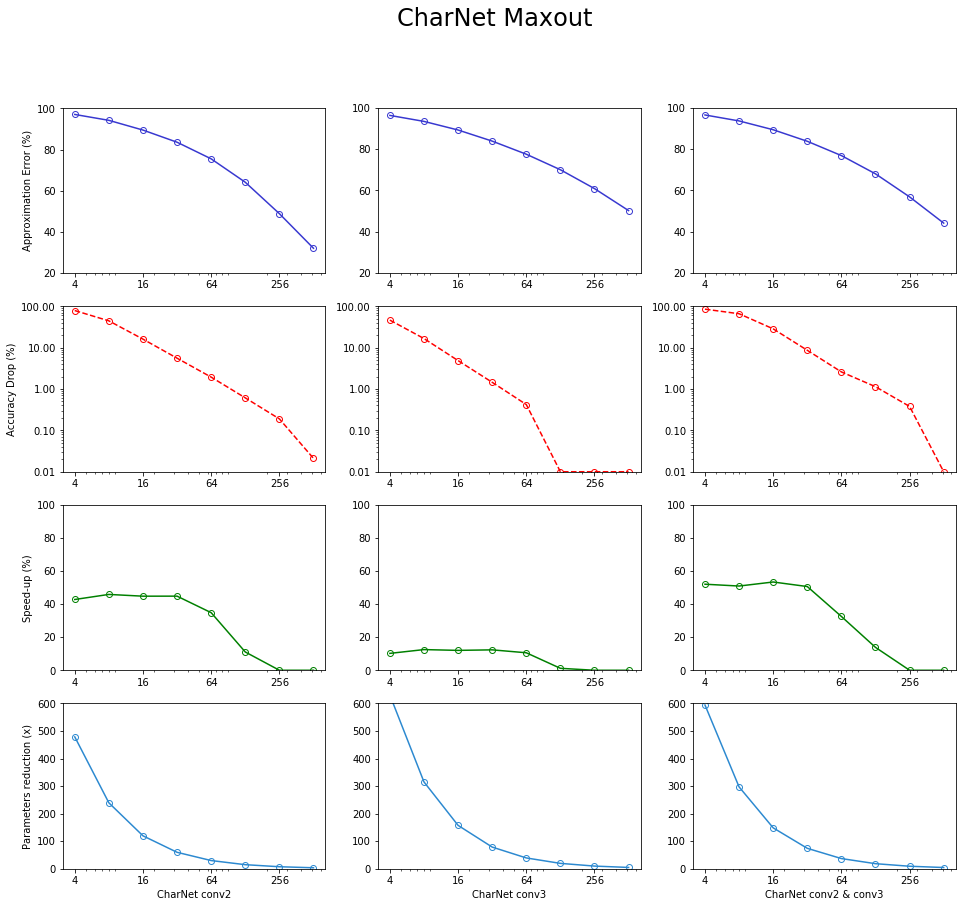

In [14]:
x = ranks_to_decomp

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)

x_labels = [4, 16, 64,  256]
err_ticks = [100, 80, 60 ,40, 20]
err_ticks1 = [100, 80, 60, 40, 30, 20 ,0]


fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(16, 14))
ax = ax.flatten()

plt.suptitle('CharNet Maxout', fontsize=24)

ax[0].plot(x, approximation_list[0], marker='o', mfc='none',  c='#3838D0')
ax[0].set_ylabel('Approximation Error (%)')
ax[0].set_xscale('log')
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[0].set_xticks(x_labels)
ax[0].set_yticks(err_ticks)


ax[1].plot(x, approximation_list[1], marker='o', mfc='none', c='#3838D0')
ax[1].set_xscale('log')
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[1].set_xticks(x_labels)
ax[1].set_yticks(err_ticks)


ax[2].plot(x, approximation_list[2], marker='o', mfc='none', c='#3838D0')
ax[2].set_xscale('log')
ax[2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[2].set_xticks(x_labels)
ax[2].set_yticks(err_ticks)


ax[3].plot(x, acc_list[0],'r--', marker='o', mfc='none', c='red')
#ax[3].plot(x, acc_ft_list[0], marker='o', mfc='none')
ax[3].set_ylabel('Accuracy Drop (%)')
ax[3].set_xscale('log')
ax[3].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[3].set_xticks(x_labels)
ax[3].set_yscale('log')
ax[3].set_yticks([100, 10, 1, 0.1, 0.01])
ax[3].yaxis.set_major_formatter(formatter)
ax[3].set_ylim([0.01,100])


ax[4].plot(x, acc_list[1],'r--', marker='o', mfc='none', c='red')
#ax[4].plot(x, acc_ft_list[1], marker='o', mfc='none')
ax[4].set_xscale('log')
ax[4].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[4].set_xticks(x_labels)
ax[4].set_yscale('log')
ax[4].set_yticks([100, 10, 1, 0.1, 0.01])
ax[4].yaxis.set_major_formatter(formatter)
ax[4].set_ylim([0.01,100])


ax[5].plot(x, acc_list[2],'r--', marker='o', mfc='none', c='red')
#ax[5].plot(x, acc_ft_list[2], marker='o', mfc='none')
ax[5].set_xscale('log')
ax[5].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[5].set_xticks(x_labels)
ax[5].set_yscale('log')
ax[5].set_yticks([100, 10, 1, 0.1, 0.01])
ax[5].yaxis.set_major_formatter(formatter)
ax[5].set_ylim([0.01,100])


ax[6].plot(x, computation_list[0], marker='o', mfc='none', c='green')
ax[6].set_ylabel('Speed-up (%)')
ax[6].set_xscale('log')
ax[6].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[6].set_xticks(x_labels)
ax[6].set_yscale('linear')
ax[6].yaxis.set_major_formatter(formatter)
ax[6].set_ylim([0,100])


ax[7].plot(x, computation_list[1], marker='o', mfc='none', c='green')
ax[7].set_xscale('log')
ax[7].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[7].set_xticks(x_labels)
ax[7].set_yscale('linear')
ax[7].yaxis.set_major_formatter(formatter)
ax[7].set_ylim([0,100])


ax[8].plot(x, computation_list[2], marker='o', mfc='none', c='green')
ax[8].set_yscale('linear')
ax[8].yaxis.set_major_formatter(formatter)
ax[8].set_xscale('log')
ax[8].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[8].set_xticks(x_labels)
ax[8].set_ylim([0,100])


ax[9].plot(x, dim_drop_list[0], marker='o', mfc='none', c='#2C89D0')
ax[9].set_ylabel('Parameters reduction (x)')
ax[9].set_xlabel('CharNet conv2')
ax[9].set_xscale('log')
ax[9].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[9].set_xticks(x_labels)
ax[9].set_ylim([0,600])


ax[10].plot(x, dim_drop_list[1], marker='o', mfc='none', c='#2C89D0')
ax[10].set_xlabel('CharNet conv3')
ax[10].set_xscale('log')
ax[10].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[10].set_xticks(x_labels)
ax[10].set_ylim([0,600])


ax[11].plot(x, dim_drop_list[2], marker='o', mfc='none', c='#2C89D0')
ax[11].set_xlabel('CharNet conv2 & conv3')
ax[11].set_xscale('log')
ax[11].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[11].set_xticks(x_labels)
ax[11].autoscale(True)
ax[11].set_ylim([0,600])


plt.show()

In [16]:
torch.cuda.is_available()

True